# Light curves distribution analysis

Obligatory import for the notebook sake.

In [78]:
import os
import lsst.afw.geom as afwGeom
import lsst.afw.table as afwTable
import pickle

import numpy as np

import lsst.daf.persistence as dafPersist
import re
import astropy.coordinates as coord
import astropy.units as u

import matplotlib.pyplot as plt
from astropy.table import Table

File containing the Mjd dictionary. Directory definition (depending wich set of data is going to be used)

In [79]:
pkl_file = open('mjd_dict.pickle', 'rb')
mjds = pickle.load(pkl_file)

directory = "nc_catalogs/6sigma"

Some useful methods

In [80]:
def source_distance(src1, src2):
    ra, dec = src1['ra'], src1['dec']
    ra2, dec2 = src2['ra'], src2['dec']
            
    return np.sqrt((float(ra)-float(ra2))**2+(float(dec)-float(dec2))**2)/3.14159*180*3600


def threshold_light_curves(light_curves, threshold):
    t_light_curves = [lc for lc in light_curves if len(lc) >= threshold]
    return t_light_curves

def build_light_curve_from_snls_file(data, c):

    bandpasses = ['r']


    lightcurve = {}
    lightcurve['bandpass'] = []
    lightcurve['mjd'] = []
    lightcurve['ra'] = []
    lightcurve['dec'] = []
    lightcurve['flux'] = []
    lightcurve['flux_error'] = []
    lightcurve['zp'] = []
    lightcurve['zpsys'] = []


    for mjd, flux, error in data:

        #print 'yep',visit
        lightcurve['bandpass'].append(str('sdss' + bandpasses[0]))
        lightcurve['mjd'].append(float(mjd))
        lightcurve['ra'].append(c.ra.radian)
        lightcurve['dec'].append(c.dec.radian)
        lightcurve['flux'].append(float(flux))
        lightcurve['flux_error'].append(float(error))
        #lightcurve['flux'].append(src['base_CircularApertureFlux_12_0_flux'])
        #lightcurve['flux_error'].append(src['base_CircularApertureFlux_12_0_fluxSigma'])
        lightcurve['zp'].append(25.0)
        lightcurve['zpsys'].append('ab')

    lc = Table(data=lightcurve)
    return lc

def build_lightcurve(source_list):
    """
    Assemble a light curve data table from available files.
    """

    bandpasses = ['r']


    lightcurve = {}
    lightcurve['classification'] = []
    lightcurve['bandpass'] = []
    lightcurve['mjd'] = []
    lightcurve['ra'] = []
    lightcurve['dec'] = []
    lightcurve['flux'] = []
    lightcurve['flux_error'] = []
    lightcurve['zp'] = []
    lightcurve['zpsys'] = []


    for visit, src in source_list:

        #print 'yep',visit
        lightcurve['classification'].append(src['classification_dipole'])
        lightcurve['bandpass'].append(str('sdss' + bandpasses[0]))
        lightcurve['mjd'].append(mjds[str(visit)])
        lightcurve['ra'].append(src['coord_ra'])
        lightcurve['dec'].append(src['coord_dec'])
        lightcurve['flux'].append(src['base_CircularApertureFlux_4_5_flux'])
        lightcurve['flux_error'].append(src['base_CircularApertureFlux_4_5_fluxSigma'])
        #lightcurve['flux'].append(src['base_CircularApertureFlux_12_0_flux'])
        #lightcurve['flux_error'].append(src['base_CircularApertureFlux_12_0_fluxSigma'])
        lightcurve['zp'].append(25.0)
        lightcurve['zpsys'].append('ab')
    lightcurve = Table(data=lightcurve)
    return lightcurve


def mean_lc_flux(lc2):

    mjds = []
    m_fluxes = []
    m_error = []
    s_error = []
    i = 0
    while i < len(lc2['mjd']):
        mjd = lc2['mjd'][i]
        j = i+1
        mjds.append(int(mjd))
        m_fluxes.append(lc2['flux'][i]*lc2['flux_error'][i])
        m_error.append(lc2['flux_error'][i])
        s_error.append(lc2['flux_error'][i]**2)
        total = 1.
       
        while j<len(lc2['mjd']) and int(lc2['mjd'][j]) == int(mjd):

            m_fluxes[-1]+= lc2['flux'][j]*lc2['flux_error'][j]
            

                
            m_error[-1] += lc2['flux_error'][j]
            s_error[-1] += (lc2['flux_error'][j]**2)
            #mjds[-1] += int(lc2['mjd'][j])
            total+=1
            j+=1
            
       
        m_fluxes[-1] = np.divide(m_fluxes[-1], m_error[-1] )
        m_error[-1] = np.divide(np.sqrt(s_error[-1]), total)
        i = j

    return mjds, m_fluxes, m_error


Light curves from SNLS are read.

06D3bz


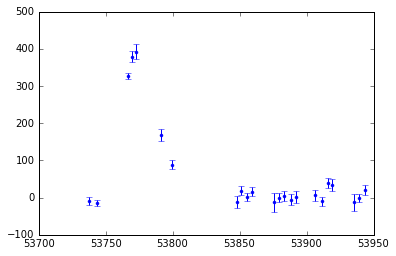

06D3cb


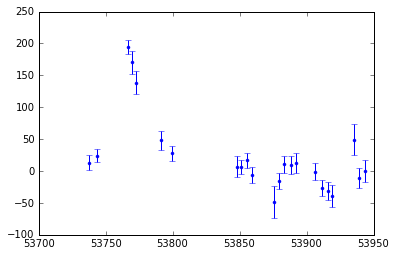

06D3cc


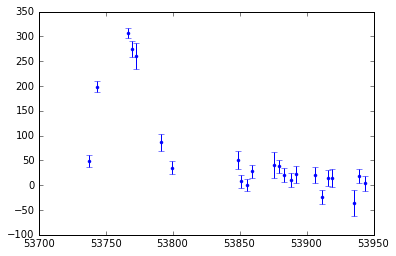

06D3cn


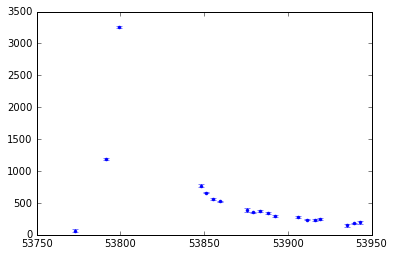

06D3df


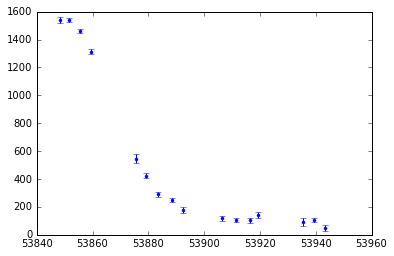

06D3dl


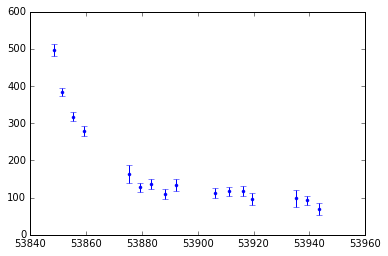

06D3do


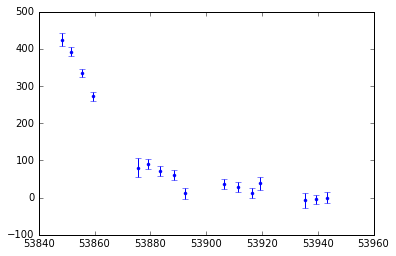

06D3dt


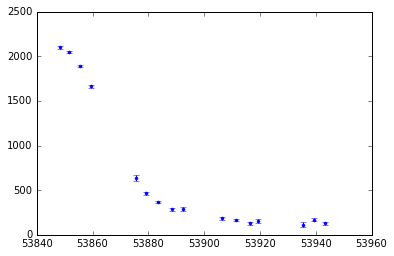

06D3ed


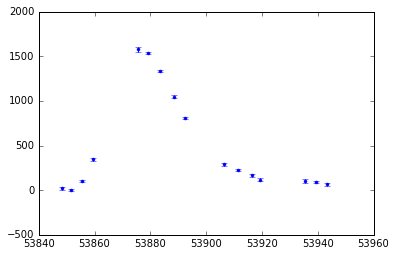

06D3el


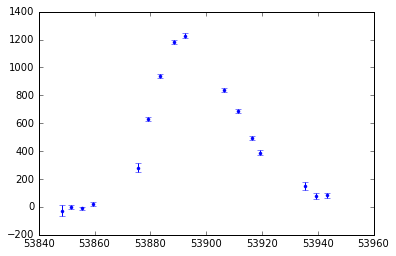

06D3em


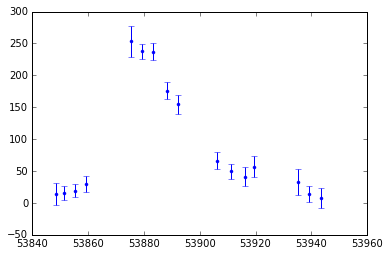

06D3en


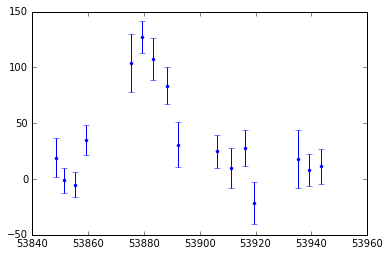

06D3et


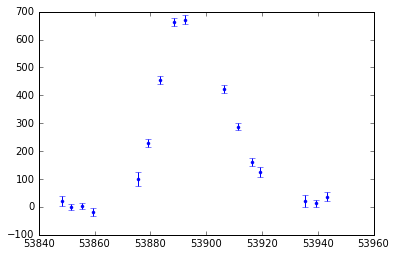

06D3fp


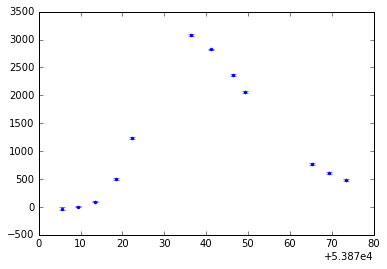

06D3gh


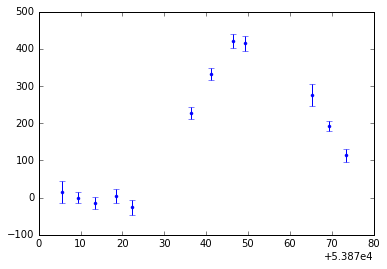

06D3gn


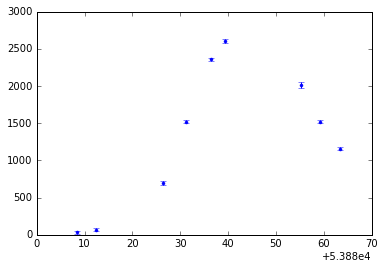

06D3gx


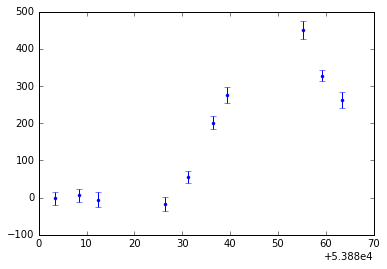

In [70]:


f = open('/renoir_data_02/jpreyes/lsst_data/sn_control/J_A+A_523_A7_table9.dat.txt','r')
data_elems = f.read()
#m = re.findall('^06D3.*?\\|(.*?)\\|', data, re.MULTILINE)
elems = re.findall('^(06D3.*?)\\|(.*?)\\|', data_elems, re.MULTILINE)

f = open('/renoir_data_02/jpreyes/lsst_data/sn_control/J_A+A_523_A7_table10.dat.txt','r')
data = f.read()


%matplotlib inline
snls_array = []
for sn in elems:
    c = coord.SkyCoord(sn[-1], unit=(u.hourangle, u.deg))
    
    m = re.findall('^'+str(sn[0])+'\\|r\\|(.*?)\\|(.*?)\\|(.*?)$', data, re.MULTILINE)

    print sn[0]
    snls_lc = build_light_curve_from_snls_file(m, c)
    plt.errorbar(snls_lc['mjd'], snls_lc['flux'], yerr=snls_lc['flux_error'], fmt='.', color='blue')
    snls_array.append(snls_lc)
    plt.show()
    
#pickle.dump(snls_array, open('/renoir_data_02/jpreyes/lsst_data/transients_files/snls_transients_filter_r.lc', 'wb'))


This method allows to create a unified catalog per visit. The twin notebook of this one performs a thresholding by removing all detections not tagged as "positive". This notebook keeps every detection with its classification.

In [89]:
in_directory = "catalogs/6sigma/"
out_directory = "nc_catalogs/6sigma/"
import lsst.afw.table as afwTable
import glob

for c_cat in visits:
    v_catalog = None
    #print "catalogs/6sigma/"+str(c_cat)+"*.fits"
    c_files = glob.glob(in_directory+str(c_cat)+"*.fits")
    
    for c_file in c_files:
        catalog = afwTable.SourceCatalog.readFits(c_file)
        
        if v_catalog is None:
            v_catalog = catalog.copy()
        else:
            v_catalog.extend(catalog)
            
    if v_catalog is not None:
        v_catalog.writeFits(out_directory+"/"+c_files[0].split("/")[-1].split("-")[0]+".fits")

Multimatch function is used to create the light curves

In [90]:
directory = "nc_catalogs/6sigma/"
files = os.listdir(directory)

multi_matches = None

for f in files:
    
    catalog = afwTable.SourceCatalog.readFits(directory+"/"+f)
    
    if multi_matches is None and len(catalog)>0:
        multi_matches = afwTable.MultiMatch(catalog[0].schema, {'visit':int}, radius=afwGeom.Angle(1./3600., afwGeom.degrees))
    if multi_matches is not None:
        multi_matches.add(catalog, {'visit':int(f.split(".")[0])})
    
results = multi_matches.finish(removeAmbiguous=False)

Light curves are thresholded using the total number of points belonging to the curve.

In [91]:
light_curves = []
i = 0
current = -1
while i < len(results):
    result = results[i]
    if current == -1 or current != result['object']:
        lc = [(result['visit'],result)]
        light_curves.append(lc)
        current = result['object']
    else:
        light_curves[-1].append((result['visit'],result))
    i+=1

t_light_curves = threshold_light_curves(light_curves, 10)
print len(t_light_curves)

7694


SNcosmo Light curve objects are created in this step.

In [92]:
#lc = build_lightcurve(t_light_curves[4])
lcs = []
for t_light_curve in t_light_curves:
    lcs.append(build_lightcurve(t_light_curve))

This method informs the match percentage with SNLS data.

In [93]:

matches = []
for sn in elems:
    
    match = False
    c = coord.SkyCoord(sn[-1], unit=(u.hourangle, u.deg))
    
    
    for i, lc in enumerate(lcs):
        #print lc[0]['ra']
        #print lc[0]['dec']
        if source_distance(lc[0], {'ra':c.ra.radian, 'dec':c.dec.radian}) < 2:
            match = True
 
            matches.append((sn[0], i))
            break
    
        #print 'no match'
print 'found ' + str(float(len(matches))/float(len(elems))) 

found 0.470588235294


Some dictionaries are created in order to visualize the light curves composition

In [232]:
props = {}

for lc in lcs:
    for point in lc:
        if props.has_key(point['classification']) == False:
            props[point['classification']] = 1
        else:
            props[point['classification']]+=1
            

            
classification_dict = {0:"Dipole type I", 1: "Dipole type II", 3:"Fringe", 4: "Artifact", 5:"Negative", 6:"Positive", 7:"Point Positive"}
marker_dict = {0:"x", 1: "x", 3:"^", 4: ".", 5:"v", 6:"*", 7:"."}

for key in classification_dict.keys():
    if props.has_key(key) == True:
        props[classification_dict[key]] = props.pop(key)

Bar plot of the category of detections on all the data.

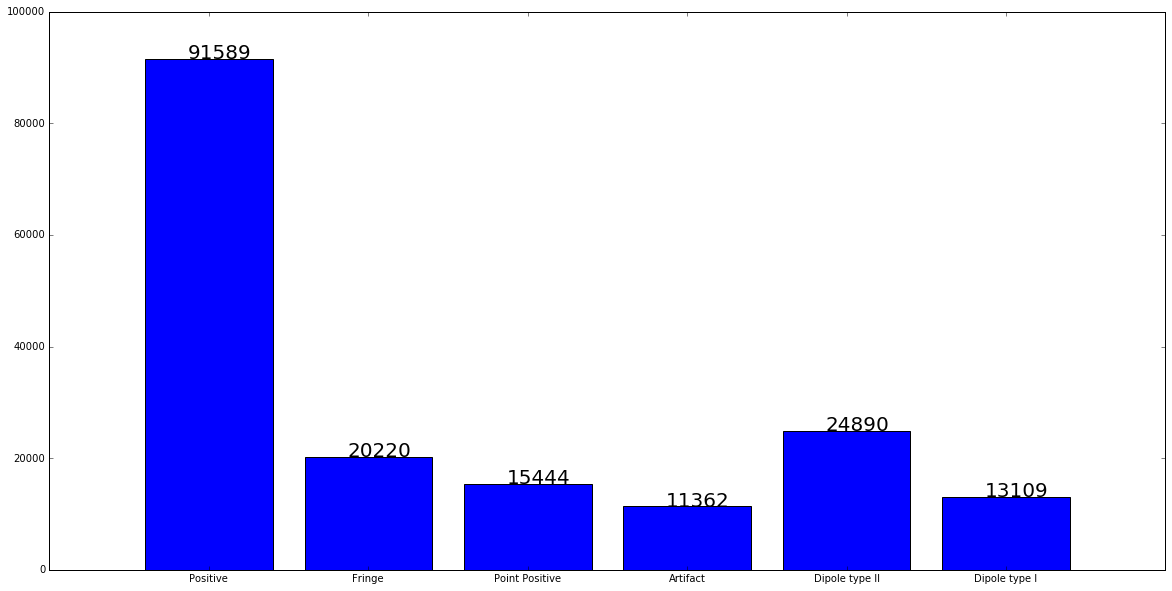

In [233]:
ind = np.arange(len(props.values())) 
plt.figure(figsize=(20,10))
p = plt.bar(ind, props.values(),  align='center')
plt.xticks(ind, props.keys())

for i, rect in enumerate(p):
    plt.text(rect.get_x()+ rect.get_width()/3, rect.get_height()+10, int(rect.get_height()), fontsize=20)

plt.show()

Composition percentage per category

In [234]:
total = 0
for key in props.keys():
    total += props[key]

for key in props.keys():
    
    print key, float(props[key])/len(lcs), str(100*float(props[key])/total)+ "%"

Positive 11.9039511308 51.8582898298%
Fringe 2.6280218352 11.4486960264%
Point Positive 2.00727839875 8.7444936415%
Artifact 1.47673511827 6.43323858811%
Dipole type II 3.23498830257 14.0928805191%
Dipole type I 1.70379516506 7.42240139513%


code for light curve visualization, while showing the different tags for each detection.

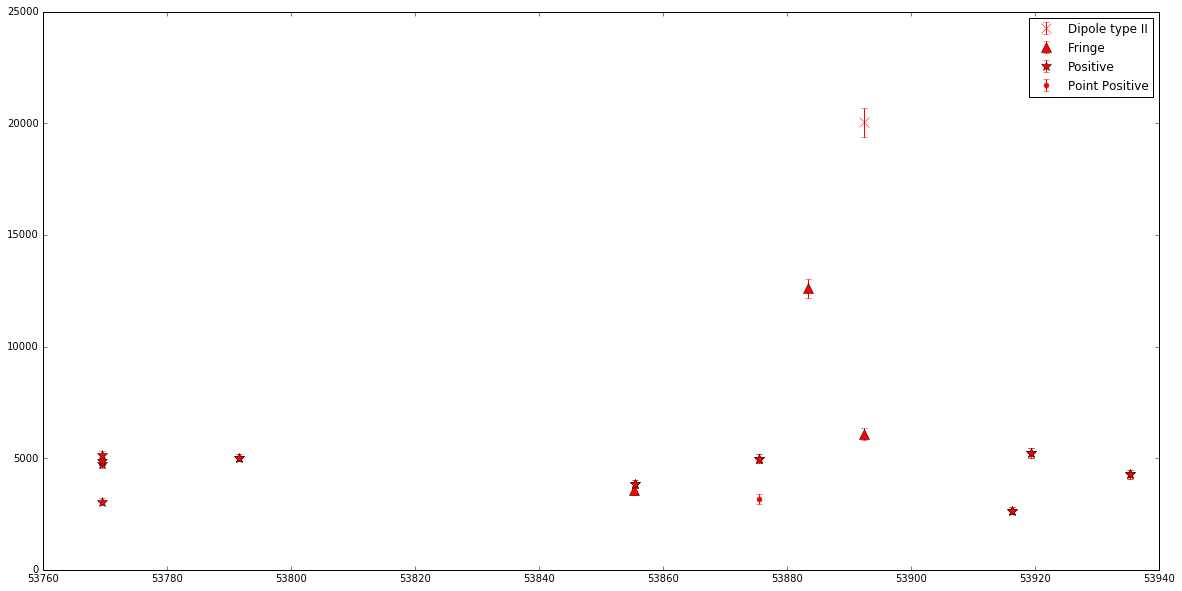

In [235]:
lc = lcs[7]
#time, m_fluxes, m_error = mean_lc_flux(lc)


plt.figure(figsize=(20,10))
#plt.errorbar(lc["mjd"], lc["flux"], yerr=lc["flux_error"], fmt='.', color='red', label='Stack', markersize=1)

class_lc = lc.group_by("classification")
indices = class_lc.groups.indices

for i in range(1, len(indices)):
    i_start = indices[i-1] 
    i_end = indices[i]
    group = class_lc[i_start:i_end]
    marker = marker_dict[group[-1]["classification"]]
    label =  classification_dict[group[-1]["classification"]]
    plt.errorbar(group["mjd"], group["flux"],  yerr=group["flux_error"], fmt=marker, color='red', label=label, markersize=10)

plt.legend(numpoints=1)

#for point in lc:
      
#    plt.plot(point["mjd"], point["flux"], marker_dict[int(point["classification"])], markersize=10, color="red")
    
plt.ylim(ymin=0)

plt.show()